Loading /content/drive/MyDrive/Colab Notebooks/MHEALTH/mhealth_raw_data.csv...
Processing 130 segments...
Saved full report to mhealth_full_quality_report.csv

=== [Low Quality Check] SNR Bottom 10 (Noise Check) ===
      Subject  Activity   SNR  Energy  Count  Kurtosis  Crest_Factor SNR_Status Transient_Status  Data_Length
24   subject2  Standing  0.01   95.77     61      0.03          1.04     Static             Weak         3072
62   subject5     Lying  0.01   95.53     57     -0.04          1.03     Static             Flat         3072
61   subject5   Sitting  0.01   95.99     59      0.09          1.03     Static             Weak         3072
85   subject7   Sitting  0.01   96.22     55      0.09          1.04     Static             Weak         3072
86   subject7     Lying  0.01   95.27     54      0.10          1.04     Static             Weak         3072
72   subject6  Standing  0.01   98.17     54      0.03          1.03     Static             Weak         3072
74   subject6 

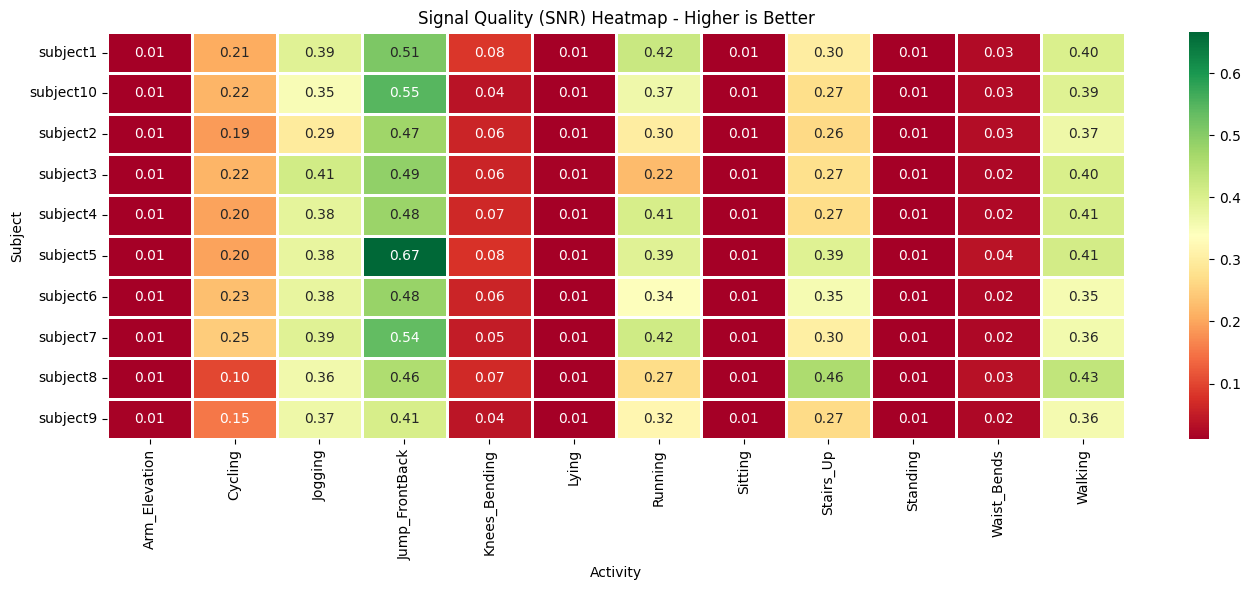

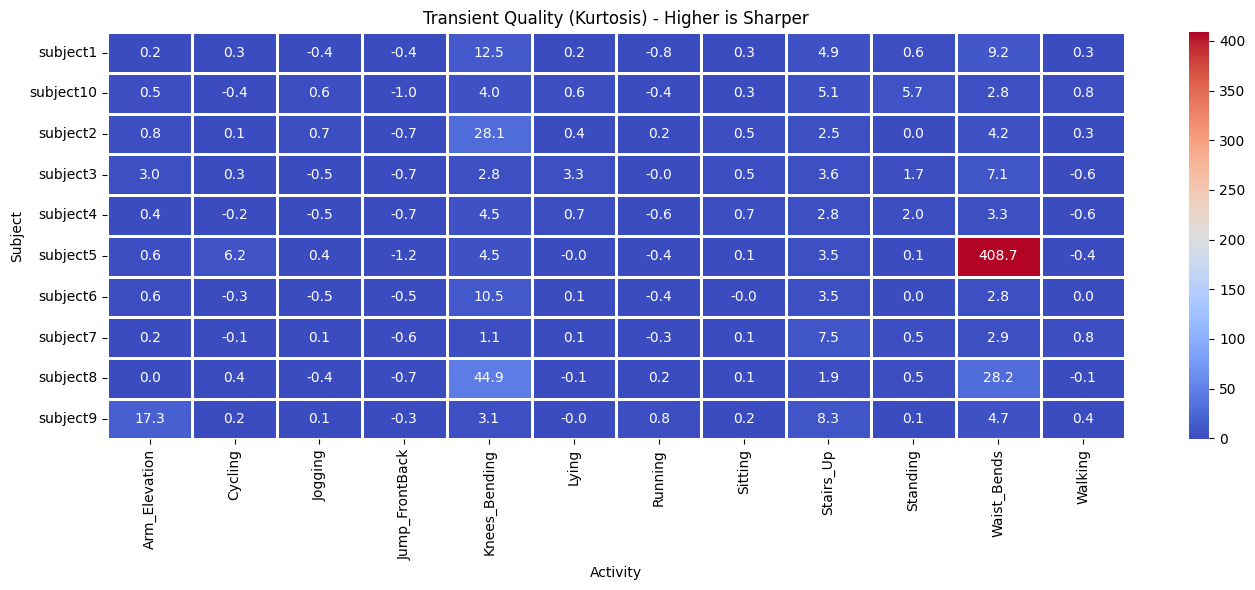

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, butter, filtfilt
from scipy.stats import kurtosis  # 첨도 계산을 위해 추가
import os

# ==========================================
# 1. 설정
# ==========================================
ACC_COLS = ['alx', 'aly', 'alz']

ACTIVITY_MAP = {
    0: 'Null', 1: 'Standing', 2: 'Sitting', 3: 'Lying',
    4: 'Walking', 5: 'Stairs_Up', 6: 'Waist_Bends',
    7: 'Arm_Elevation', 8: 'Knees_Bending', 9: 'Cycling',
    10: 'Jogging', 11: 'Running', 12: 'Jump_FrontBack'
}

# ==========================================
# 2. 계산 로직 (Helper Functions)
# ==========================================

def calculate_basic_metrics(acc_data, fs=50):
    """SNR, Energy, Peak Count 계산"""
    mag = np.linalg.norm(acc_data, axis=1)

    # Energy
    energy = np.mean(mag**2)

    # SNR
    std_val = np.std(mag)
    mean_val = np.mean(np.abs(mag)) + 1e-6
    snr = std_val / mean_val

    # Peak Count
    b, a = butter(4, 3/(fs/2), btype='low')
    smooth_mag = filtfilt(b, a, mag)
    peaks, _ = find_peaks(smooth_mag, distance=25, prominence=std_val*0.5)
    count = len(peaks)

    return round(snr, 3), round(energy, 2), count

def calculate_transient_metrics(acc_data):
    """Kurtosis, Crest Factor 계산"""
    mag = np.linalg.norm(acc_data, axis=1)

    # Kurtosis (Fisher=True -> 정규분포=0)
    kurt_val = kurtosis(mag, fisher=True)

    # Crest Factor
    peak_val = np.max(np.abs(mag))
    rms_val = np.sqrt(np.mean(mag**2))
    crest_factor = peak_val / rms_val if rms_val != 0 else 0

    return round(kurt_val, 2), round(crest_factor, 2)

def get_snr_status(activity_name, snr):
    """SNR 기반 상태 판정"""
    if activity_name in ['Standing', 'Sitting', 'Lying', 'Null']:
        return 'Static'

    if snr > 0.15: return 'Good'
    elif snr > 0.08: return 'Fair'
    else: return 'Bad'

def get_transient_status(kurt, crest):
    """첨도/파고율 기반 전이 특성 판정"""
    if kurt > 5.0 and crest > 4.0: return 'Excellent' # 아주 날카로움
    elif kurt > 2.0 and crest > 2.5: return 'Good'    # 준수함
    elif kurt < 0: return 'Flat'                      # 뭉개짐
    else: return 'Weak'

# ==========================================
# 3. 통합 분석 실행 (핵심 수정 부분)
# ==========================================

def analyze_full_quality(file_path):
    print(f"Loading {file_path}...")
    df = pd.read_csv(file_path)

    results = []

    # 그룹핑 (Subject x Activity)
    grouped = df.groupby(['subject', 'Activity'])
    print(f"Processing {len(grouped)} segments...")

    for (subj, act_id), group in grouped:
        if act_id == 0: continue

        act_name = ACTIVITY_MAP.get(act_id, f'Unknown_{act_id}')
        acc_data = group[ACC_COLS].values

        # 1. 기본 지표 계산 (SNR, Energy)
        snr, energy, count = calculate_basic_metrics(acc_data)

        # 2. 전이 지표 계산 (Kurtosis, Crest Factor)
        kurt, crest = calculate_transient_metrics(acc_data)

        # 3. 상태 판정
        snr_status = get_snr_status(act_name, snr)
        trans_status = get_transient_status(kurt, crest)

        # 4. 통합 결과 저장
        results.append({
            'Subject': subj,
            'Activity': act_name,
            'SNR': snr,                 # 신호 선명도
            'Energy': energy,           # 에너지
            'Count': count,             # 피크 수
            'Kurtosis': kurt,           # 첨도 (전이 날카로움)
            'Crest_Factor': crest,      # 파고율
            'SNR_Status': snr_status,   # SNR 상태
            'Transient_Status': trans_status, # 전이 상태
            'Data_Length': len(group)
        })

    result_df = pd.DataFrame(results)

    # CSV 저장 (모든 지표 포함)
    output_filename = 'mhealth_full_quality_report.csv'
    result_df.to_csv(output_filename, index=False)
    print(f"Saved full report to {output_filename}")

    return result_df

# ==========================================
# 4. 시각화 (두 가지 Heatmap 모두 그리기)
# ==========================================

def plot_heatmaps(df):
    # 1. SNR Heatmap
    pivot_snr = df.pivot(index='Subject', columns='Activity', values='SNR')
    plt.figure(figsize=(14, 6))
    sns.heatmap(pivot_snr, cmap='RdYlGn', annot=True, fmt=".2f", linewidths=1, linecolor='white')
    plt.title('Signal Quality (SNR) Heatmap - Higher is Better')
    plt.tight_layout()
    plt.show()

    # 2. Kurtosis Heatmap
    pivot_kurt = df.pivot(index='Subject', columns='Activity', values='Kurtosis')
    plt.figure(figsize=(14, 6))
    sns.heatmap(pivot_kurt, cmap='coolwarm', annot=True, fmt=".1f", linewidths=1, linecolor='white')
    plt.title('Transient Quality (Kurtosis) - Higher is Sharper')
    plt.tight_layout()
    plt.show()

# ==========================================
# 5. 메인 실행
# ==========================================
file_path = '/content/drive/MyDrive/Colab Notebooks/MHEALTH/mhealth_raw_data.csv'

if os.path.exists(file_path):
    # 통합 분석 수행
    df_result = analyze_full_quality(file_path)

    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None) # 모든 컬럼 보기
    pd.set_option('display.width', 1000)

    print("\n=== [Low Quality Check] SNR Bottom 10 (Noise Check) ===")
    print(df_result.sort_values(by='SNR').head(10))

    print("\n=== [Transient Check] Kurtosis Top 10 (Sharpest Movements) ===")

    print(df_result.sort_values(by='Kurtosis', ascending=False).head(10)[['Subject', 'Activity', 'Kurtosis', 'Crest_Factor', 'Transient_Status']])

    # 시각화 실행
    plot_heatmaps(df_result)

else:
    print(f"파일을 찾을 수 없습니다: {file_path}")

Loading /content/drive/MyDrive/Colab Notebooks/MHEALTH/mhealth_raw_data.csv...
Processing 130 segments...

=== SNR Analysis Report (Top 10 Rows) ===
       Subject       Activity    SNR  Energy  Count  Status  Data_Length
24    subject2       Standing  0.010   95.77     61  Static         3072
62    subject5          Lying  0.010   95.53     57  Static         3072
61    subject5        Sitting  0.010   95.99     59  Static         3072
85    subject7        Sitting  0.010   96.22     55  Static         3072
86    subject7          Lying  0.010   95.27     54  Static         3072
72    subject6       Standing  0.010   98.17     54  Static         3072
74    subject6          Lying  0.010   96.87     56  Static         3072
108   subject9       Standing  0.010   98.46     60  Static         3072
98    subject8          Lying  0.010   94.22     64  Static         3072
109   subject9        Sitting  0.010   96.84     63  Static         3072
90    subject7  Arm_Elevation  0.010   97.60    

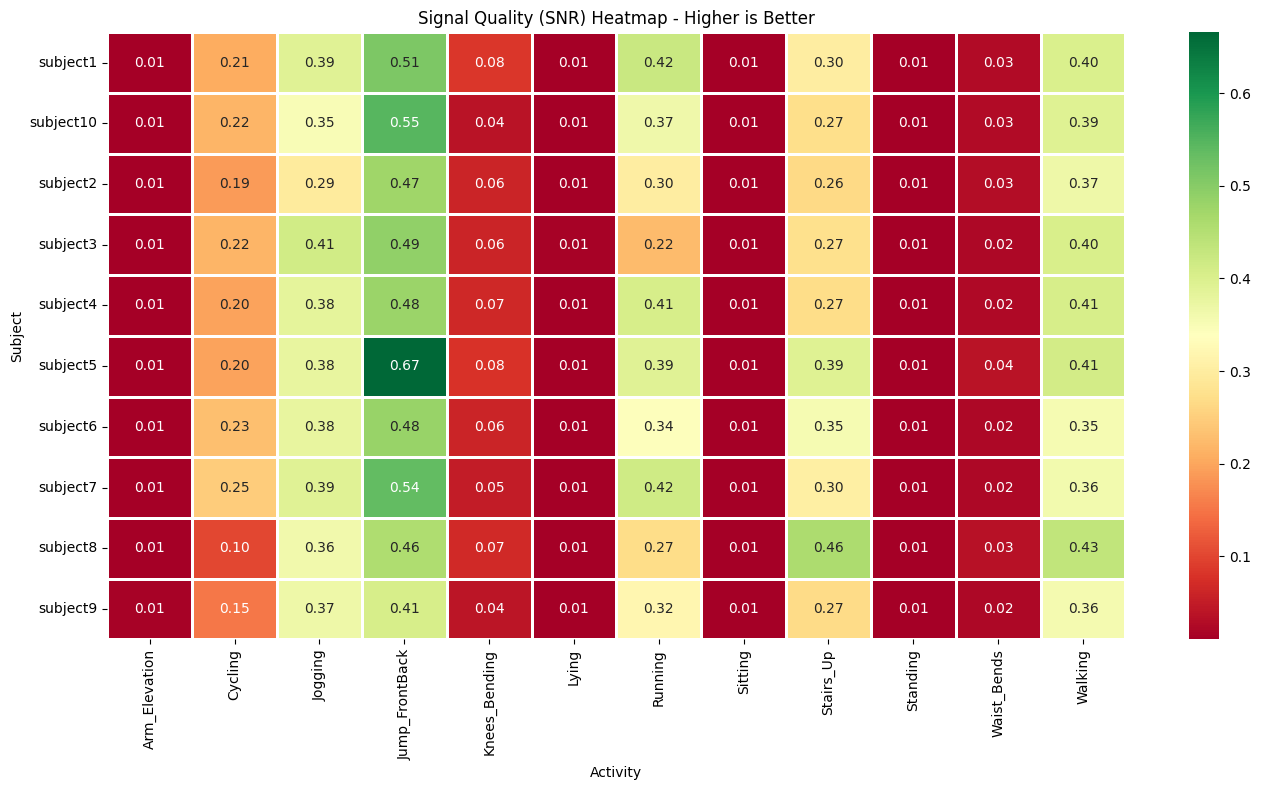


=== Transient Quality Report (Top 10 Sharpest) ===


KeyError: 'Kurtosis'

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, butter, filtfilt
import os

# ==========================================
# 1. 설정
# ==========================================
ACC_COLS = ['alx', 'aly', 'alz']

ACTIVITY_MAP = {
    0: 'Null', 1: 'Standing', 2: 'Sitting', 3: 'Lying',
    4: 'Walking', 5: 'Stairs_Up', 6: 'Waist_Bends',
    7: 'Arm_Elevation', 8: 'Knees_Bending', 9: 'Cycling',
    10: 'Jogging', 11: 'Running', 12: 'Jump_FrontBack'
}

# ==========================================
# 2. 핵심 로직: SNR & Energy 계산
# ==========================================

def calculate_metrics(acc_data, fs=50):
    # Magnitude 계산
    mag = np.linalg.norm(acc_data, axis=1)

    # 1. Energy (신호의 강도)
    # 움직임이 없으면 0에 수렴, 격렬하면 큼
    energy = np.mean(mag**2)

    # 2. SNR (Signal Quality)
    # HAR에서는 보통 "동적 범위(std) / 정적 노이즈(mean)" 비율을 간단한 SNR로 봅니다.
    # 값이 클수록 "확실하게 굽이치는 신호"라는 뜻입니다.
    # (Standing 같은 정지 동작은 SNR이 낮은 게 정상이나, 여기선 '움직임의 질'을 보므로 낮게 나옴)
    std_val = np.std(mag)
    mean_val = np.mean(np.abs(mag)) + 1e-6
    snr = std_val / mean_val

    # 3. Reference Count (단순 참고용)
    # Low-pass filter 후 Peak 개수만 셈
    b, a = butter(4, 3/(fs/2), btype='low')
    smooth_mag = filtfilt(b, a, mag)
    peaks, _ = find_peaks(smooth_mag, distance=25, prominence=std_val*0.5)
    count = len(peaks)

    return round(snr, 3), round(energy, 2), count

def get_quality_status(activity_name, snr, energy):
    """
    SNR과 Energy를 기반으로 Good/Bad 판정
    """
    # 정지 동작 (Standing, Sitting, Lying)
    if activity_name in ['Standing', 'Sitting', 'Lying', 'Null']:
        return 'Static' # 정지 동작은 SNR 평가 제외 (따로 관리)

    # 동적 동작 (Walking, Running, Exercise...)
    # 기준: SNR이 0.1 이상이고 에너지가 충분해야 함 (수치는 데이터 보며 조정)
    if snr > 0.15:
        return 'Good'
    elif snr > 0.08:
        return 'Fair'
    else:
        return 'Bad' # 신호가 너무 약하거나 노이즈에 묻힘

# ==========================================
# 3. 전체 실행
# ==========================================

def analyze_mhealth_quality(file_path):
    print(f"Loading {file_path}...")
    df = pd.read_csv(file_path)

    results = []

    # 그룹핑 (Subject x Activity)
    grouped = df.groupby(['subject', 'Activity'])
    print(f"Processing {len(grouped)} segments...")

    for (subj, act_id), group in grouped:
        if act_id == 0: continue # Null class 생략 가능

        act_name = ACTIVITY_MAP.get(act_id, f'Unknown_{act_id}')
        acc_data = group[ACC_COLS].values

        # 지표 계산
        snr, energy, count = calculate_metrics(acc_data)

        # 상태 판정
        status = get_quality_status(act_name, snr, energy)

        results.append({
            'Subject': subj,
            'Activity': act_name,
            'SNR': snr,       # 신호 선명도 (높을수록 좋음)
            'Energy': energy, # 움직임 강도
            'Count': count,   # 단순 횟수 (참고)
            'Status': status, # Good / Fair / Bad / Static
            'Data_Length': len(group)
        })

    result_df = pd.DataFrame(results)
    result_df.to_csv('mhealth_snr_report.csv', index=False)
    return result_df

# ==========================================
# 4. 시각화 (SNR Heatmap)
# ==========================================


# ==========================================
# 핵심 로직: 전이/이벤트 품질 지표 계산
# ==========================================

def calculate_transient_metrics(acc_data):
    # 1. Magnitude (벡터 합)
    mag = np.linalg.norm(acc_data, axis=1)

    # 2. Kurtosis (첨도) - 전이 구간 평가의 핵심!
    # 정규분포(노이즈)는 0(혹은 3)에 가깝고,
    # 날카로운 이벤트가 있으면 값이 5~10 이상으로 치솟음.
    # fisher=True면 정규분포=0, False면 정규분포=3. 여기선 True 사용.
    kurt_val = kurtosis(mag, fisher=True)

    # 3. Crest Factor (파고율)
    # Peak값 / RMS값
    peak_val = np.max(np.abs(mag))
    rms_val = np.sqrt(np.mean(mag**2))

    if rms_val == 0: crest_factor = 0
    else: crest_factor = peak_val / rms_val

    # 4. Energy (움직임 강도) - 보조 지표
    energy = np.mean(mag**2)

    return round(kurt_val, 2), round(crest_factor, 2), round(energy, 2)

def get_transient_status(kurt, crest):
    """
    첨도와 파고율을 기반으로 전이/이벤트 품질 판정
    """
    # 기준값은 데이터 특성에 따라 튜닝 필요
    # 보통 충격/전이 신호는 첨도 > 3.0, 파고율 > 3.0 이면 아주 뚜렷함

    if kurt > 5.0 and crest > 4.0:
        return 'Excellent' # 아주 날카롭고 명확한 동작
    elif kurt > 2.0 and crest > 2.5:
        return 'Good'      # 준수한 동작
    elif kurt < 0:
        return 'Flat'      # 너무 뭉개짐 (거의 등속도거나 정지)
    else:
        return 'Weak'      # 동작이 희미함

# ==========================================
# 전체 분석 실행
# ==========================================

def analyze_transient_quality(file_path):
    print(f"Loading {file_path}...")
    df = pd.read_csv(file_path)

    results = []

    # Subject x Activity 그룹핑
    grouped = df.groupby(['subject', 'Activity'])

    for (subj, act_id), group in grouped:
        if act_id == 0: continue

        act_name = ACTIVITY_MAP.get(act_id, f'Unknown_{act_id}')
        acc_data = group[ACC_COLS].values

        # 지표 계산 (Kurtosis, Crest Factor)
        kurt, crest, energy = calculate_transient_metrics(acc_data)
        status = get_transient_status(kurt, crest)

        results.append({
            'Subject': subj,
            'Activity': act_name,
            'Kurtosis': kurt,       # 높을수록 "날카로운" 전이
            'Crest_Factor': crest,  # 높을수록 "뚜렷한" 전이
            'Energy': energy,       # 움직임의 총량
            'Status': status,
            'Rows': len(group)
        })

    return pd.DataFrame(results)

# ==========================================
# 시각화 (Kurtosis Heatmap)
# ==========================================

def plot_transient_heatmap(df):
    # Kurtosis가 높을수록 전이 탐지에 유리한 "명확한 데이터"
    pivot = df.pivot(index='Subject', columns='Activity', values='Kurtosis')

    plt.figure(figsize=(14, 8))

    # 색상: 낮음(파랑/뭉개짐) -> 높음(빨강/날카로움)
    sns.heatmap(pivot, cmap='coolwarm',
                annot=True, fmt=".1f",
                linewidths=1, linecolor='white')

    plt.title('Transient Quality (Kurtosis) - Higher is Sharper')
    plt.tight_layout()
    plt.show()

def plot_snr_heatmap(df):
    # 정지 동작(Static)은 SNR 비교가 불공정하므로 시각화에서 제외하거나 0 처리
    # 여기서는 동적 행위 위주로 보기 위해 제외하지 않고 그대로 그립니다.

    pivot = df.pivot(index='Subject', columns='Activity', values='SNR')

    plt.figure(figsize=(14, 8))

    # SNR은 높을수록 좋으므로 붉은색(낮음) -> 초록색(높음)
    sns.heatmap(pivot, cmap='RdYlGn',
                annot=True, fmt=".2f", # 각 셀에 SNR 값 직접 표시
                linewidths=1, linecolor='white')

    plt.title('Signal Quality (SNR) Heatmap - Higher is Better')
    plt.tight_layout()
    plt.show()

# --- 실행 ---
file_path = '/content/drive/MyDrive/Colab Notebooks/MHEALTH/mhealth_raw_data.csv'

if os.path.exists(file_path):
    # 1. 분석 실행
    df_result = analyze_mhealth_quality(file_path)

    # 2. 결과 출력 (모든 행 보기 설정)
    pd.set_option('display.max_rows', None)

    print("\n=== SNR Analysis Report (Top 10 Rows) ===")
    # SNR이 낮은 순서대로 정렬해서 'Bad' 데이터를 먼저 확인
    print(df_result.sort_values(by='SNR').head(20))

    # 3. 히트맵 그리기
    plot_snr_heatmap(df_result)

else:
    print("CSV 파일이 없습니다.")

print("\n=== Transient Quality Report (Top 10 Sharpest) ===")
print(df_result.sort_values(by='Kurtosis', ascending=False).head(10))

# 히트맵
plot_transient_heatmap(df_result)

# CSV 저장
df_result.to_csv('mhealth_transient_report.csv', index=False)